## Import Modules

In [4]:
import os
from numpy.random import seed
seed(888)

import tensorflow as tf
tf.random.set_seed(404)
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [5]:
def load_csv_from_zip(zip_path: str, filename: str, header=None, as_array: bool = True) -> pd.DataFrame:
    """
    Load a CSV file directly from a ZIP archive.

    Parameters
    ----------
    zip_path : str
        Path to the ZIP archive.
    filename : str
        Name of the CSV file inside the ZIP archive.
    header : int, list of int, or None, default None
        Row(s) to use as the column names. Use None to keep all rows as data.
    as_array : bool, default True
        If True, return as a NumPy array. If False, return as a DataFrame.

    Returns
    -------
    np.ndarray or pd.DataFrame
        Data in array or DataFrame format.
    """
    with zipfile.ZipFile(zip_path) as z:
        with z.open(filename) as f:
            df = pd.read_csv(f, header=header)
    return df.values if as_array else df

ZIP_PATH = "../data/MNIST.zip"

x_train_all = load_csv_from_zip(ZIP_PATH, "digit_xtrain.csv")
x_test = load_csv_from_zip(ZIP_PATH, "digit_xtest.csv")
y_train_all = load_csv_from_zip(ZIP_PATH, "digit_ytrain.csv")
y_test = load_csv_from_zip(ZIP_PATH, "digit_ytest.csv")

## EDA

x_train shape: (60000, 784)
y_train shape: (60000, 1)
x_test shape: (10000, 784)
y_test shape: (10000, 1)


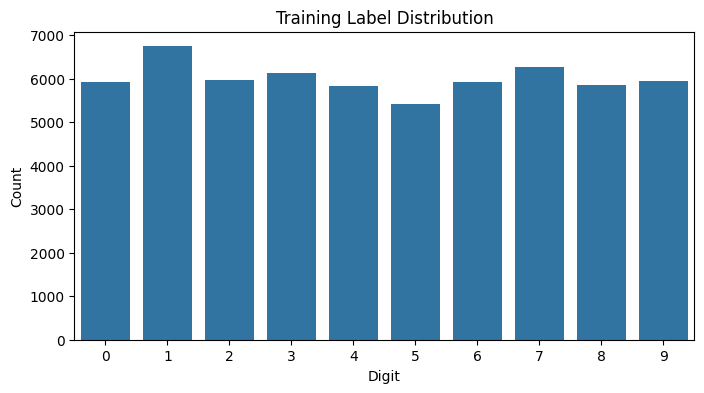

Missing values in x_train: 0
Missing values in y_train: 0
Missing values in x_test: 0
Missing values in y_test: 0
Pixel range in x_train: 0 to 255
Pixel range in x_test: 0 to 255


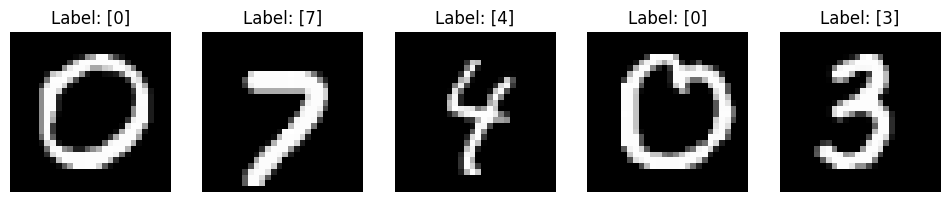

Train mean pixel value: 33.318421449829934
Train std pixel value: 78.56748998339742
Test mean pixel value: 33.791224489795916
Test std pixel value: 79.1724632222863


In [6]:
def eda_mnist(x_train, y_train, x_test, y_test, sample_size=5):
    # 1. Check shapes
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

    # 2. Check label distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x=y_train.flatten())
    plt.title("Training Label Distribution")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

    # 3. Check missing values
    print("Missing values in x_train:", np.isnan(x_train).sum())
    print("Missing values in y_train:", np.isnan(y_train).sum())
    print("Missing values in x_test:", np.isnan(x_test).sum())
    print("Missing values in y_test:", np.isnan(y_test).sum())

    # 4. Check pixel value ranges
    print("Pixel range in x_train:", x_train.min(), "to", x_train.max())
    print("Pixel range in x_test:", x_test.min(), "to", x_test.max())

    # 5. Show random samples
    plt.figure(figsize=(12, 3))
    indices = np.random.choice(len(x_train), sample_size, replace=False)
    for i, idx in enumerate(indices):
        img = x_train[idx].reshape(28, 28)
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Label: {y_train[idx]}")
    plt.show()

    # 6. Basic statistics
    print("Train mean pixel value:", np.mean(x_train))
    print("Train std pixel value:", np.std(x_train))
    print("Test mean pixel value:", np.mean(x_test))
    print("Test std pixel value:", np.std(x_test))

eda_mnist(x_train_all, y_train_all, x_test, y_test)

## Data Pre-processing

### Re-scale

In [7]:
# Re-scale data between 0 - 1
x_train_all, x_test = x_train_all/255.0 , x_test / 255.0

### Convert target values to one-hot encoding

In [8]:
NUM_CLASSES = 10

y_train_all = np.eye(NUM_CLASSES)[y_train_all.ravel()]
y_test = np.eye(NUM_CLASSES)[y_test.ravel()]

### Create Validation set from training data

In [9]:
VALIDATION_SIZE = 10000

x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

## MLP Model Training

In [10]:
# --- One-hot setup (labels are already (N, 10) in the previous step) ---
# Note: We need to perform one-hot encoding before training
NUM_CLASSES = 10  # fixed for MNIST
LR = 1e-3
EPOCHS = 50
BATCH_SIZE = 128

NUM_LAYER_1 = 512
NUM_LAYER_2 = 64

# -------- Loss & metrics for ONE-HOT labels --------
loss_obj  = keras.losses.CategoricalCrossentropy()
train_acc = keras.metrics.CategoricalAccuracy(name="train_acc")
val_acc   = keras.metrics.CategoricalAccuracy(name="val_acc")

In [11]:
# -------- Build an MLP (Flattened input) --------
model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),  # e.g., 784
    layers.Dense(
        NUM_LAYER_1, activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42),
        bias_initializer=keras.initializers.Zeros(),
        name="dense_512"
    ),
    layers.Dropout(0.2, name="dropout_0_2"),  # keep 80% of output
    layers.Dense(
        NUM_LAYER_2, activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42),
        bias_initializer=keras.initializers.Zeros(),
        name="dense_64"
    ),
    layers.Dense(
        NUM_CLASSES, activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1, seed=42),
        bias_initializer=keras.initializers.Zeros(),
        name="classifier"
    ),
], name="mnist_mlp_onehot")

optimizer = keras.optimizers.Adam(LR)

# -------- tf.data pipelines --------
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val,   y_val)).batch(BATCH_SIZE)

# -------- TensorBoard writers (optional) --------
train_writer = tf.summary.create_file_writer("logs/custom/train")
val_writer   = tf.summary.create_file_writer("logs/custom/val")

# -------- One training step --------
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)  # enable dropout
        loss   = loss_obj(y, y_pred)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_acc.update_state(y, y_pred)
    return loss

# -------- One validation step --------
@tf.function
def val_step(x, y):
    y_pred = model(x, training=False)  # disable dropout
    v_loss = loss_obj(y, y_pred)
    val_acc.update_state(y, y_pred)
    return v_loss

In [12]:
# -------- Training loop --------
train_losses, val_losses = [], []
train_accs, val_accs     = [], []

for epoch in range(EPOCHS):
    # --- train ---
    train_acc.reset_state()
    epoch_train_loss = 0.0
    batches = 0
    for xb, yb in train_ds:
        loss = train_step(xb, yb)
        epoch_train_loss += loss
        batches += 1
    epoch_train_loss = epoch_train_loss / tf.cast(batches, tf.float32)

    # --- validate ---
    val_acc.reset_state()
    epoch_val_loss = 0.0
    vbatches = 0
    for xb, yb in val_ds:
        vloss = val_step(xb, yb)
        epoch_val_loss += vloss
        vbatches += 1
    epoch_val_loss = epoch_val_loss / tf.cast(vbatches, tf.float32)

    # --- TensorBoard (optional) ---
    with train_writer.as_default():
        tf.summary.scalar("loss", epoch_train_loss, step=epoch)
        tf.summary.scalar("accuracy", train_acc.result(), step=epoch)
    with val_writer.as_default():
        tf.summary.scalar("loss", epoch_val_loss, step=epoch)
        tf.summary.scalar("accuracy", val_acc.result(), step=epoch)

    # --- log & collect history ---
    print(f"Epoch {epoch:02d} | "
          f"Train Loss {epoch_train_loss:.4f} Acc {train_acc.result():.4f} | "
          f"Val Loss {epoch_val_loss:.4f} Acc {val_acc.result():.4f}")

    train_losses.append(float(epoch_train_loss))
    val_losses.append(float(epoch_val_loss))
    train_accs.append(float(train_acc.result()))
    val_accs.append(float(val_acc.result()))

print("Done training!")

2025-09-06 17:30:19.587354: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-06 17:30:19.713331: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 00 | Train Loss 0.3253 Acc 0.9027 | Val Loss 0.1628 Acc 0.9521


2025-09-06 17:30:20.886672: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 01 | Train Loss 0.1293 Acc 0.9611 | Val Loss 0.1067 Acc 0.9690
Epoch 02 | Train Loss 0.0865 Acc 0.9735 | Val Loss 0.0931 Acc 0.9723


2025-09-06 17:30:23.172344: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 03 | Train Loss 0.0626 Acc 0.9807 | Val Loss 0.0765 Acc 0.9758
Epoch 04 | Train Loss 0.0503 Acc 0.9842 | Val Loss 0.0704 Acc 0.9790
Epoch 05 | Train Loss 0.0403 Acc 0.9870 | Val Loss 0.0778 Acc 0.9778
Epoch 06 | Train Loss 0.0329 Acc 0.9890 | Val Loss 0.0746 Acc 0.9787


2025-09-06 17:30:27.766720: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 07 | Train Loss 0.0284 Acc 0.9906 | Val Loss 0.0706 Acc 0.9790
Epoch 08 | Train Loss 0.0241 Acc 0.9923 | Val Loss 0.0754 Acc 0.9790
Epoch 09 | Train Loss 0.0203 Acc 0.9931 | Val Loss 0.0710 Acc 0.9804
Epoch 10 | Train Loss 0.0212 Acc 0.9929 | Val Loss 0.0674 Acc 0.9827
Epoch 11 | Train Loss 0.0181 Acc 0.9938 | Val Loss 0.0737 Acc 0.9808
Epoch 12 | Train Loss 0.0154 Acc 0.9947 | Val Loss 0.0792 Acc 0.9816
Epoch 13 | Train Loss 0.0157 Acc 0.9948 | Val Loss 0.0843 Acc 0.9801
Epoch 14 | Train Loss 0.0130 Acc 0.9956 | Val Loss 0.0927 Acc 0.9795


2025-09-06 17:30:36.931925: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 | Train Loss 0.0162 Acc 0.9945 | Val Loss 0.0962 Acc 0.9774
Epoch 16 | Train Loss 0.0139 Acc 0.9950 | Val Loss 0.0857 Acc 0.9814
Epoch 17 | Train Loss 0.0137 Acc 0.9951 | Val Loss 0.0864 Acc 0.9812
Epoch 18 | Train Loss 0.0121 Acc 0.9963 | Val Loss 0.0799 Acc 0.9821
Epoch 19 | Train Loss 0.0096 Acc 0.9966 | Val Loss 0.0837 Acc 0.9821
Epoch 20 | Train Loss 0.0124 Acc 0.9960 | Val Loss 0.0840 Acc 0.9830
Epoch 21 | Train Loss 0.0085 Acc 0.9972 | Val Loss 0.0905 Acc 0.9826
Epoch 22 | Train Loss 0.0123 Acc 0.9957 | Val Loss 0.0929 Acc 0.9808
Epoch 23 | Train Loss 0.0113 Acc 0.9961 | Val Loss 0.0998 Acc 0.9804
Epoch 24 | Train Loss 0.0095 Acc 0.9968 | Val Loss 0.0898 Acc 0.9813
Epoch 25 | Train Loss 0.0095 Acc 0.9970 | Val Loss 0.0982 Acc 0.9818
Epoch 26 | Train Loss 0.0093 Acc 0.9970 | Val Loss 0.1011 Acc 0.9815
Epoch 27 | Train Loss 0.0105 Acc 0.9965 | Val Loss 0.0994 Acc 0.9813
Epoch 28 | Train Loss 0.0077 Acc 0.9971 | Val Loss 0.0956 Acc 0.9822
Epoch 29 | Train Loss 0.0097 Acc 0

2025-09-06 17:30:53.412973: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31 | Train Loss 0.0071 Acc 0.9976 | Val Loss 0.1053 Acc 0.9831
Epoch 32 | Train Loss 0.0107 Acc 0.9964 | Val Loss 0.0996 Acc 0.9821
Epoch 33 | Train Loss 0.0079 Acc 0.9972 | Val Loss 0.1094 Acc 0.9802
Epoch 34 | Train Loss 0.0075 Acc 0.9976 | Val Loss 0.0904 Acc 0.9838
Epoch 35 | Train Loss 0.0065 Acc 0.9979 | Val Loss 0.0993 Acc 0.9821
Epoch 36 | Train Loss 0.0074 Acc 0.9973 | Val Loss 0.0981 Acc 0.9813
Epoch 37 | Train Loss 0.0067 Acc 0.9977 | Val Loss 0.0977 Acc 0.9833
Epoch 38 | Train Loss 0.0073 Acc 0.9976 | Val Loss 0.1090 Acc 0.9802
Epoch 39 | Train Loss 0.0089 Acc 0.9973 | Val Loss 0.0976 Acc 0.9822
Epoch 40 | Train Loss 0.0070 Acc 0.9979 | Val Loss 0.1087 Acc 0.9815
Epoch 41 | Train Loss 0.0103 Acc 0.9967 | Val Loss 0.0985 Acc 0.9825
Epoch 42 | Train Loss 0.0063 Acc 0.9981 | Val Loss 0.0993 Acc 0.9819
Epoch 43 | Train Loss 0.0054 Acc 0.9981 | Val Loss 0.1024 Acc 0.9825
Epoch 44 | Train Loss 0.0061 Acc 0.9982 | Val Loss 0.1033 Acc 0.9830
Epoch 45 | Train Loss 0.0088 Acc 0

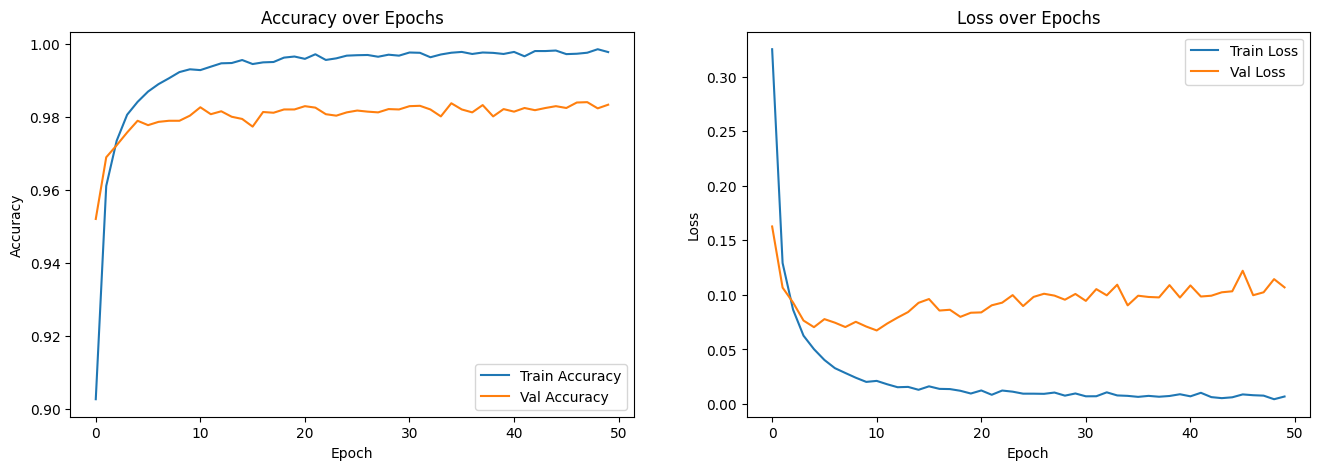

In [13]:
# -------- Plot curves --------
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy over Epochs"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss over Epochs"); plt.legend()
plt.show()

## Make a Prediction

In [16]:
from PIL import Image

zip_path = "../data/MNIST.zip"

with zipfile.ZipFile(zip_path) as z:
    with z.open("test_img.png") as f:
        img = Image.open(f)
        img = img.convert("L")   

img

In [17]:
img_array = np.array(img)

# 2. Invert colors if your training data is white text on black background
img_array = np.invert(img_array)

# 3. Normalize like training data (0–1)
img_array = img_array.astype("float32") / 255.0

# 4. Reshape to match model input
test_img = img_array.reshape(1, 28*28) 

# 5. Predict
probs = model.predict(test_img)  # shape (1, 10)
pred = np.argmax(probs, axis=1)

print(f"Prediction for test image is {pred[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for test image is 2


## Testing and Evaluation

Test accuracy: 0.9828 | Test loss: 0.0949


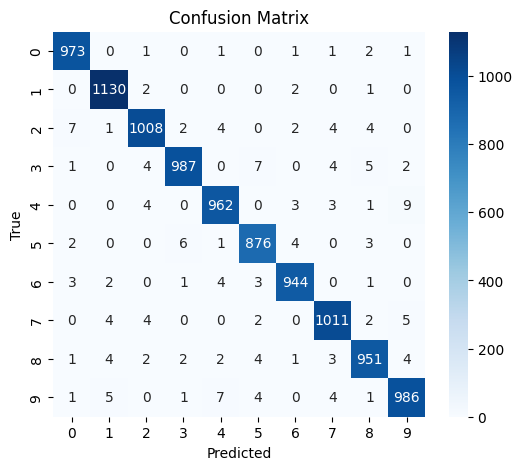

              precision    recall  f1-score   support

           0     0.9848    0.9929    0.9888       980
           1     0.9860    0.9956    0.9908      1135
           2     0.9834    0.9767    0.9801      1032
           3     0.9880    0.9772    0.9826      1010
           4     0.9806    0.9796    0.9801       982
           5     0.9777    0.9821    0.9799       892
           6     0.9864    0.9854    0.9859       958
           7     0.9816    0.9835    0.9825      1028
           8     0.9794    0.9764    0.9779       974
           9     0.9791    0.9772    0.9782      1009

    accuracy                         0.9828     10000
   macro avg     0.9827    0.9827    0.9827     10000
weighted avg     0.9828    0.9828    0.9828     10000



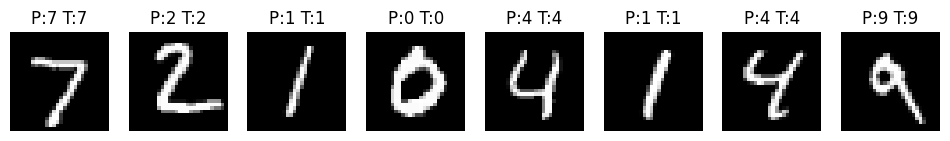

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1) compile for evaluation (pick the correct loss by your label format)
is_one_hot = (y_train.ndim == 2 and y_train.shape[1] > 1)
loss_name  = "categorical_crossentropy" if is_one_hot else "sparse_categorical_crossentropy"

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=loss_name,
              metrics=["accuracy"])

# 2) evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# 3) predictions
probs = model.predict(x_test, verbose=0)         # (N, num_classes)
preds = probs.argmax(axis=1)
true  = y_test.argmax(axis=1) if is_one_hot else y_test.reshape(-1)

# 4) confusion matrix & report
cm = confusion_matrix(true, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

print(classification_report(true, preds, digits=4))

# 5) visualize a few predictions
plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap="gray")
    plt.axis("off")
    plt.title(f"P:{preds[i]} T:{true[i]}")
plt.show()


## Saving Model

In [22]:
model.export("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  5574617680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5601750352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5574617104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5601754000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5601752080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5601750928: TensorSpec(shape=(), dtype=tf.resource, name=None)


You will need this command to convert model into `.js` file

> Please run the command inside the `model` directory, not from the project root.

```bash
tensorflowjs_converter --input_format=tf_saved_model --signature_name=serving_default --saved_model_tags=serve saved_model mnist_tfjs_model/ 
```

## Load and Test the Saved Model

In [24]:
import numpy as np
import tensorflow as tf

def test_saved_model(
    saved_model_path: str,
    x_test: np.ndarray,
    y_test: np.ndarray,
    sample_indices=None,
    batch_size: int = 128,
    topk: int = 3,
):
    """
    Quick sanity check for a SavedModel exported from Keras.

    - Prints available signatures and the exact input/output tensor names.
    - Evaluates a mini-batch accuracy on x_test/y_test.
    - Shows per-sample predictions for a few chosen indices (top-k).
    """
    print("=== 1) Load SavedModel ===")
    loaded = tf.saved_model.load(saved_model_path)
    sig_names = list(loaded.signatures.keys())
    print(f"Available signatures: {sig_names}")

    # Use the standard serving function
    infer = loaded.signatures["serving_default"]

    print("\n=== 2) I/O names (align with TF.js GraphModel) ===")
    print("Input signature:", infer.structured_input_signature)
    print("Output signature:", infer.structured_outputs)

    # Grab the actual output key (usually 'output_0')
    out_keys = list(infer.structured_outputs.keys())
    out_key = out_keys[0]
    print(f"Chosen output key: {out_key}")

    # Ensure float32 and same preprocessing as training (e.g., /255.0)
    x_test = x_test.astype("float32", copy=False)

    # If labels are one-hot -> convert to integer class ids for reporting
    if y_test.ndim == 2 and y_test.shape[1] > 1:
        y_int = y_test.argmax(axis=1)
    else:
        y_int = y_test

    # Mini-batch evaluation (quick, not full test set)
    n = min(len(x_test), 1000)  # evaluate on up to 1000 samples for speed
    print(f"\n=== 3) Mini-batch evaluation on first {n} test samples ===")
    acc_count = 0
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        xb = tf.convert_to_tensor(x_test[start:end], dtype=tf.float32)
        preds = infer(xb)[out_key].numpy()        # (B, 10) probabilities
        acc_count += (preds.argmax(axis=1) == y_int[start:end]).sum()

    mini_acc = acc_count / n
    print(f"Mini-batch accuracy: {mini_acc:.4f}")

    # Choose which samples to show
    if sample_indices is None:
        sample_indices = list(range(10))  # by default: the first 10 images

    print(f"\n=== 4) Per-sample predictions (top-{topk}) ===")
    print("Index | True | Pred | Top-k (class:prob)")
    print("-" * 48)
    for idx in sample_indices:
        xb = tf.convert_to_tensor(x_test[idx:idx+1], dtype=tf.float32)
        probs = infer(xb)[out_key].numpy().reshape(-1)  # (10,)
        pred = int(probs.argmax())
        truth = int(y_int[idx])

        # top-k breakdown
        top_idx = probs.argsort()[::-1][:topk]
        top_str = ", ".join([f"{c}:{probs[c]:.3f}" for c in top_idx])
        print(f"{idx:5d} | {truth:4d} | {pred:4d} | {top_str}")

    print("\nNote:")
    print("- Input name you will use in TF.js GraphModel: the name shown in the input signature (e.g., 'keras_tensor').")
    print(f"- Output name to fetch in TF.js: '{out_key}'.")
    print("- Probabilities should sum to ~1 for each sample (softmax at export).")


SM_PATH = "../model/saved_model"


test_saved_model(
    saved_model_path=SM_PATH,
    x_test=x_test,
    y_test=y_test,
    sample_indices=[0, 3, 7, 10, 23],  # pick any indices you want to inspect
    batch_size=128,
    topk=3,
)

=== 1) Load SavedModel ===
Available signatures: ['serve', 'serving_default']

=== 2) I/O names (align with TF.js GraphModel) ===
Input signature: ((), {'keras_tensor': TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')})
Output signature: {'output_0': TensorSpec(shape=(None, 10), dtype=tf.float32, name='output_0')}
Chosen output key: output_0

=== 3) Mini-batch evaluation on first 1000 test samples ===
Mini-batch accuracy: 0.9860

=== 4) Per-sample predictions (top-3) ===
Index | True | Pred | Top-k (class:prob)
------------------------------------------------
    0 |    7 |    7 | 7:1.000, 9:0.000, 3:0.000
    3 |    0 |    0 | 0:1.000, 6:0.000, 1:0.000
    7 |    9 |    9 | 9:1.000, 3:0.000, 7:0.000
   10 |    0 |    0 | 0:1.000, 2:0.000, 7:0.000
   23 |    5 |    5 | 5:1.000, 3:0.000, 9:0.000

Note:
- Input name you will use in TF.js GraphModel: the name shown in the input signature (e.g., 'keras_tensor').
- Output name to fetch in TF.js: 'output_0'.
- Probabiliti